In [1]:
import sys
sys.path.append('C:/Users/sseir/PycharmProjects/trimkmeans/src')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_s_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.metrics import completeness_score
from trimkmeans.trimkmeans import TrimKMeans
from trimkmeans.metrics import trimmed_kmeans_metric_unsupervised
from trimkmeans.metrics import trimmed_kmeans_metric_supervised
from sklearn.cluster import KMeans

In [3]:
def plot_clustering(n_samples,
                    centers,
                    distribution,
                    cluster_method,
                    noise = 0.0,
                    runs= 1,
                    cluster_std= 1,
                    metrics= [],
                    plot= True,
                    trim=0.1,
                    n_cluster=None,
                    return_centers= False,
                    init= 'k-means++'):
    #if no n_cluster is provided its assumed that centers and n_clusters are equal
    if not n_cluster:
        n_cluster = centers
    # Create a dataset of 2D distributions
    if distribution == 'make_blobs':
        if return_centers:
            X_train, true_labels, centers = make_blobs(n_samples=n_samples,
                                                       centers=centers,
                                                       random_state=42,
                                                       cluster_std= cluster_std,
                                                       return_centers = return_centers)
        else:
            X_train, true_labels = make_blobs(n_samples=n_samples, centers=centers, random_state=42, cluster_std= cluster_std)
    elif distribution == 'make_moons':
        X_train, true_labels = make_moons(n_samples=1000, random_state=42, noise= noise)
    elif distribution == 'make_circles':
        X_train, true_labels = make_circles(n_samples=1000, random_state=42, noise= noise)
    #https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html
    elif distribution == 'anisotropicly_distributed':
        if n_cluster != 3:
            raise ValueError('anisotropicly_distributed needs 3 clusters')
        X, true_labels = make_blobs(n_samples=n_samples, random_state=42)
        transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
        X_train = np.dot(X, transformation)
    elif distribution == 'different_variance':
        if n_cluster != 3:
            raise ValueError('anisotropicly_distributed needs 3 clusters')
        X_train, true_labels = make_blobs(n_samples=n_samples, random_state=42, cluster_std=[1.0, 2.5, 0.5])
    elif distribution == 'unevenly_sized':
        if n_cluster != 3:
            raise ValueError('anisotropicly_distributed needs 3 clusters')
        X, y = make_blobs(n_samples=1500, random_state=42)
        X_train = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
        true_labels = ([0] * 500) + ([1] *100) + ([2] *10)
    elif distribution == 'make_s_curve':
        X_train, true_labels = make_s_curve(n_samples=1000, random_state=42, noise= noise)
    elif distribution == 'make_swiss_roll':
        X_train, true_labels = make_swiss_roll(n_samples=1000, random_state=42, noise= noise)
    else:
        raise ValueError('''distribution unknown, try make_blobs, make_moons and make_circles for 2D
                         or make_s_curve and make_swiss_roll for 3D''')
        
    scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #if return_centers:
    #   centers = scaler.transform(centers)
    # Fit centroids to dataset
    if cluster_method == 'trimmed_kmeans':
        if return_centers:
            cluster_object = TrimKMeans(n_clusters=n_cluster, trim=trim, n_init=runs, init= centers)
        elif isinstance(init, str) and init == "random":
            cluster_object = TrimKMeans(n_clusters=n_cluster, trim=trim, n_init=runs, init= 'random')
        else: 
            cluster_object = TrimKMeans(n_clusters=n_cluster, trim=trim, n_init=runs)
        cluster_object.fit(X_train)
        labels = cluster_object.predict(X_train)
    elif cluster_method == 'kmeans':
        cluster_object = KMeans(n_clusters=n_cluster, random_state=42, n_init=runs)
        cluster_object.fit(X_train)
        labels = cluster_object.predict(X_train)
    else:
        raise ValueError('cluster_method unknown, try trimmed_kmeans or kmeans')
    
    if (plot):
        # View results
        if distribution in ['make_s_curve', 'make_swiss_roll']:
            fig1 = plt.figure()
            ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
            ax1.set_position([0, 0, 0.95, 1])
            for l in np.unique(labels):
                ax1.scatter(
                    X_train[labels == l, 0],
                    X_train[labels == l, 1],
                    X_train[labels == l, 2],
                    color=plt.cm.jet(float(l) / np.max(labels)),
                    s=20,
                    edgecolor="k",
                )
        else:
            sns.scatterplot(x=[X[0] for X in X_train],
                            y=[X[1] for X in X_train],
                            hue=labels,
                            style=labels,
                            palette="deep",
                            legend=None
                            )
            plt.plot([x for x, _ in cluster_object.cluster_centers_],
                     [y for _, y in cluster_object.cluster_centers_],
                     'k+',
                     markersize=10,
                     )
            if cluster_method == 'trimmed_kmeans':
                for idx, centroid in enumerate(cluster_object.cluster_centers_):
                    circle = plt.Circle(centroid, cluster_object.opt_cutoff_ranges[idx], fill=False, color='r')
                    plt.gca().add_patch(circle)
        plt.show()
    if 'silhouette_score' in metrics:
        if cluster_method == 'trimmed_kmeans':
            print('silhouette score: ', trimmed_kmeans_metric_unsupervised(X_train, labels, 'silhouette_score'))
        else:
            print('silhouette score: ', silhouette_score(X_train, labels, metric='euclidean'))
    if 'rand_score' in metrics: 
        if cluster_method == 'trimmed_kmeans':
            print('rand score: ', trimmed_kmeans_metric_supervised(true_labels, labels, 'rand_score'))
        else:
            print('rand score: ',rand_score(true_labels, labels))
    if 'completeness_score' in metrics:
        if cluster_method == 'trimmed_kmeans':
            print('completeness score: ', trimmed_kmeans_metric_supervised(true_labels, labels, 'completeness_score'))
        else:
            print('completeness score: ', completeness_score(true_labels, labels))
    if 'sed' in metrics:
        if cluster_method == 'trimmed_kmeans':
            print('even distribution score: ', trimmed_kmeans_metric_unsupervised(X_train, labels, 'sed'))
    if 'sv' in metrics:
        if cluster_method == 'trimmed_kmeans':
            print('sum of variances: ', trimmed_kmeans_metric_unsupervised(X_train, labels, 'sv'))
    if return_centers:
        return centers, X_train
    return None

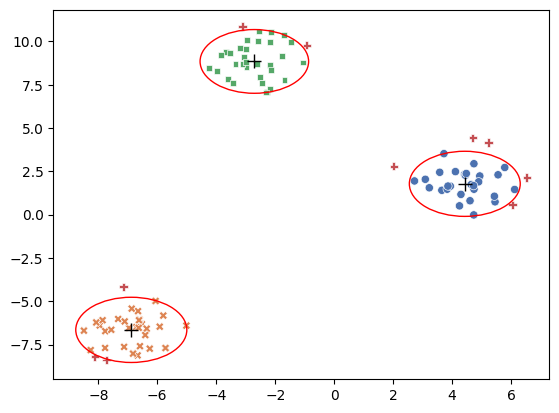

In [4]:
#trimmedkmeans 100 samples three centers example
plot_clustering(100, 3, distribution= 'make_blobs', cluster_method= 'trimmed_kmeans', runs=50, init='random')

In [5]:
%load_ext rpy2.ipython

Unable to determine R home: [WinError 2] Das System kann die angegebene Datei nicht finden
C:\Python310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


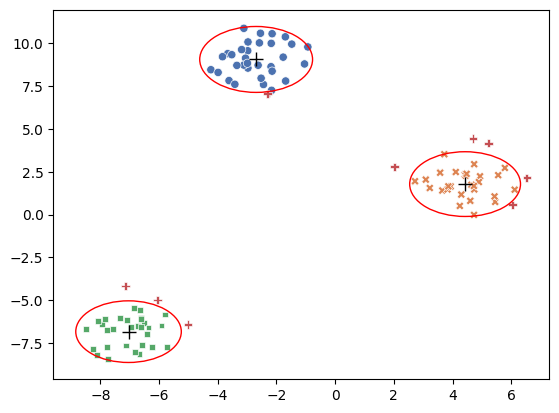

In [6]:
#create python and r clustering from the same centers generated by make_blobs()
#shows that the same points are trimmed of in both versions
make_blob_centers, make_blob_data = plot_clustering(100,
                                                    3,
                                                    distribution= 'make_blobs',
                                                    cluster_method= 'trimmed_kmeans',
                                                    runs=10,
                                                    return_centers=True)

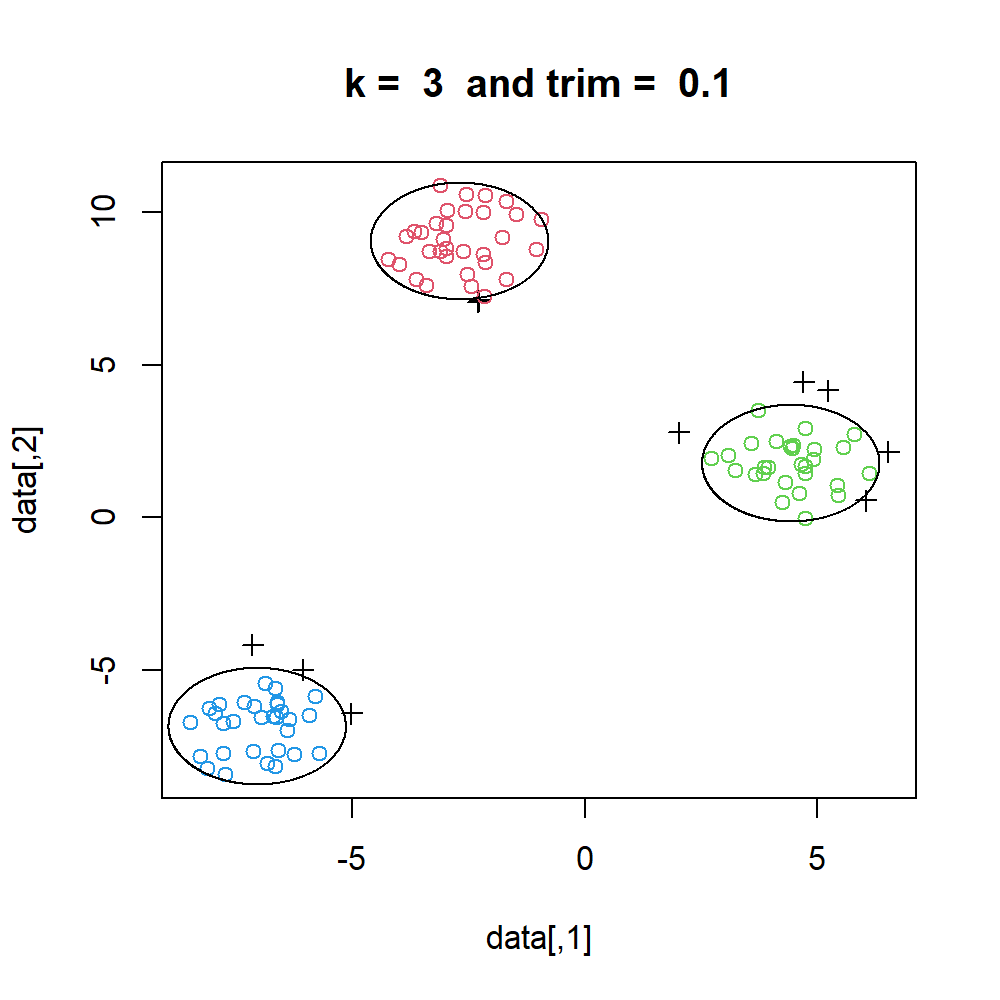

In [7]:
%%R -i make_blob_centers,make_blob_data -w 5 -h 5 --units in -r 200

library(trimcluster)

tkm1 <- trimkmeans(data=make_blob_data, k=3, trim=0.1, runs=10, points=make_blob_centers)
plot(tkm1, make_blob_data)

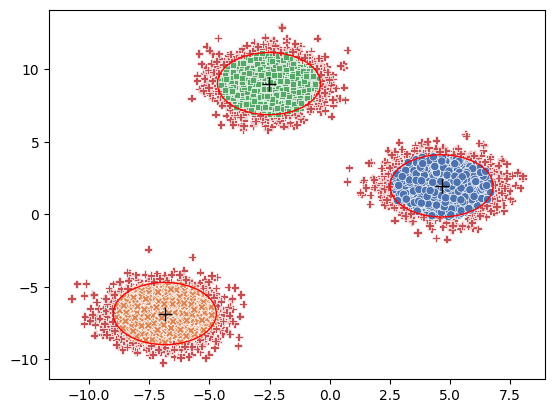

In [8]:
#trimmedkmeans 10000 samples three centers
plot_clustering(10000, 3, distribution= 'make_blobs', runs= 10, cluster_method= 'trimmed_kmeans')

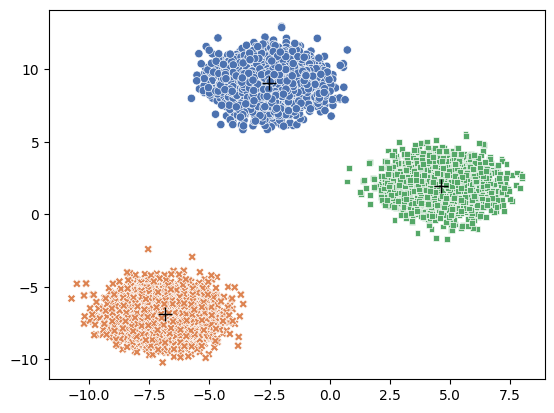

In [9]:
#kmeans 10000 samples three centers
plot_clustering(10000, 3, distribution= 'make_blobs', cluster_method= 'kmeans')

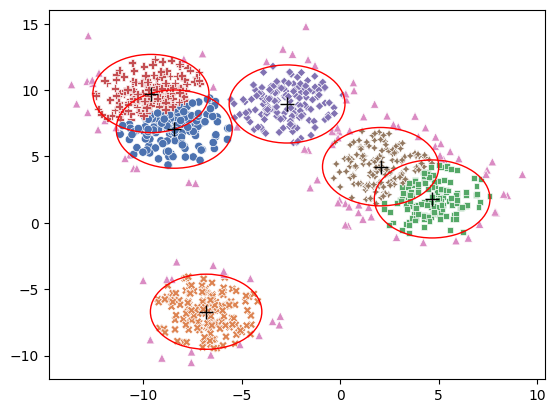

silhouette score:  0.5122727801233684


In [10]:
#create a less evenly distributed dataset so metrics will not generate perfect scores and a clearer comparison can be achieved
plot_clustering(1000,
                6,
                distribution= 'make_blobs',
                cluster_method= 'trimmed_kmeans',
                cluster_std=1.5,
                runs=10,
                metrics = ['silhouette_score'])

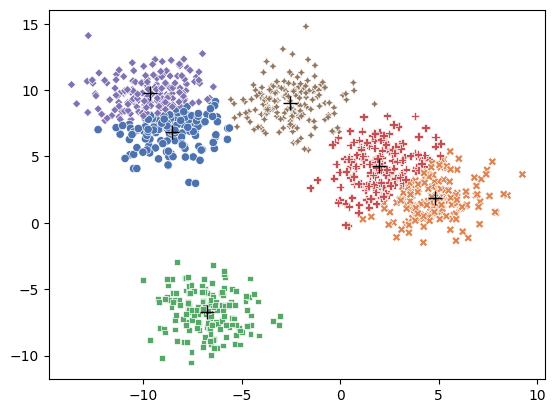

silhouette score:  0.4803741030809177


In [11]:
#Silhouette score for kmeans n_samples=1000, centers = 6, cluster_std=1.5
plot_clustering(1000,
                6,
                distribution= 'make_blobs',
                cluster_method= 'kmeans',
                runs=10,
                cluster_std=1.5, metrics = ['silhouette_score'])

In [4]:
METRICS = ['silhouette_score', 'rand_score', 'completeness_score', 'sed', 'sv']

In [13]:
#metrics for trimmed kmeans n_samples=1000, centers = 5, cluster_std=1.5, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'trimmed_kmeans',
                cluster_std=1.5,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.6007904491536278
rand score:  0.9574613768384624
completeness score:  0.886025374452806
even distribution score:  18.927996835979663
sum of variances:  109.55769524150047


In [14]:
#metrics for kmeans n_samples=1000, centers = 5, cluster_std=1.5, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'kmeans',
                cluster_std=1.5,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.567374474890988
rand score:  0.9559019019019019
completeness score:  0.8743484265987004


In [15]:
#metrics for trimmed kmeans n_samples=1000, centers = 10, cluster_std=1.5, runs 20
plot_clustering(1000,
                10,
                distribution= 'make_blobs',
                cluster_method= 'trimmed_kmeans',
                cluster_std=1.5,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.4890082890390771
rand score:  0.9499048325299716
completeness score:  0.8312787514417623
even distribution score:  39.9523376479546
sum of variances:  252.59418164728314


In [16]:
#metrics for kmeans n_samples=1000, centers = 10, cluster_std=1.5, runs 20
plot_clustering(1000,
                10,
                distribution= 'make_blobs',
                cluster_method= 'kmeans',
                cluster_std=1.5,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.44939617635336665
rand score:  0.9482862862862863
completeness score:  0.8089086858670418


In [17]:
#metrics for trimmed kmeans n_samples=1000, centers = 5, cluster_std=2, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'trimmed_kmeans',
                cluster_std=2,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.5120882196418362
rand score:  0.9229094055122976
completeness score:  0.791517893437868
even distribution score:  20.21410935046711
sum of variances:  115.97183919133563


In [18]:
#metrics for kmeans n_samples=1000, centers = 5, cluster_std=2, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'kmeans',
                cluster_std=2,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.4839035466416629
rand score:  0.9265685685685686
completeness score:  0.795794660012909


In [19]:
#metrics for trimmed kmeans n_samples=1000, centers = 5, cluster_std=2, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'trimmed_kmeans',
                cluster_std=2,
                metrics = METRICS,
                runs=20,
                trim=0.3,
                plot=False)

silhouette score:  0.5742240466947761
rand score:  0.9243490701001431
completeness score:  0.8093793581664711
even distribution score:  19.251481547780173
sum of variances:  112.77230455437227


In [20]:
#metrics for trimmed kmeans n_samples=1000, centers = 5, cluster_std=4, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'trimmed_kmeans',
                cluster_std=4,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.36840942395038356
rand score:  0.7935755778024965
completeness score:  0.45241444767583655
even distribution score:  26.30180128972471
sum of variances:  165.68631368203398


In [5]:
#metrics for kmeans n_samples=1000, centers = 5, cluster_std=4, runs 20
plot_clustering(1000,
                5,
                distribution= 'make_blobs',
                cluster_method= 'kmeans',
                cluster_std=4,
                metrics = METRICS,
                runs=20,
                plot=False)

silhouette score:  0.3415455051858287
rand score:  0.7971791791791791
completeness score:  0.46150980314254275


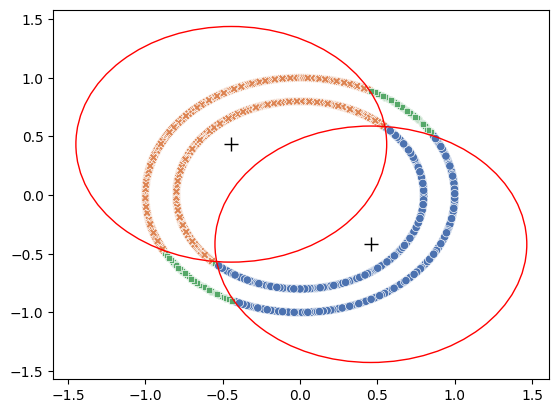

silhouette score:  0.4621911685241097
rand score:  0.4994438264738598
completeness score:  0.0
even distribution score:  1.2658497494431815
sum of variances:  0.8011878326012126


In [22]:
#metrics for trimmedkmeans 1000 samples from make_circles
plot_clustering(1000,
                2,
                distribution= 'make_circles',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                runs=20)

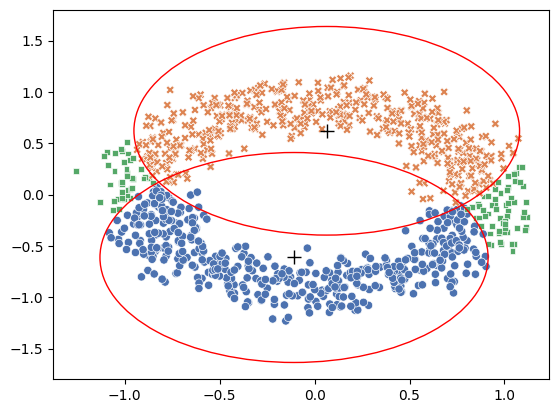

silhouette score:  0.45807105944292276
rand score:  0.49948337659127423
completeness score:  5.1506696922389506e-05
even distribution score:  1.0578989365931406
sum of variances:  0.559607473999


In [23]:
#metrics for trimmedkmeans 1000 samples from make_circles with noise
plot_clustering(1000,
                2,
                distribution= 'make_circles',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                noise=0.1,
                runs=20)

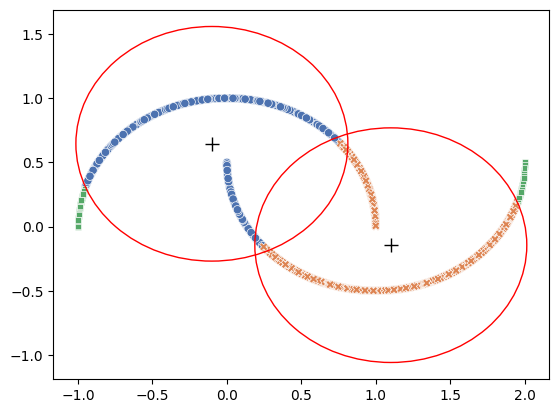

silhouette score:  0.4946809932466178
rand score:  0.6234729946854529
completeness score:  0.18696555103007964
even distribution score:  1.3041832919490042
sum of variances:  0.8686624865180258


In [24]:
#metrics for trimmedkmeans 1000 samples from make_moons
plot_clustering(1000,
                2,
                distribution= 'make_moons',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                runs=20)

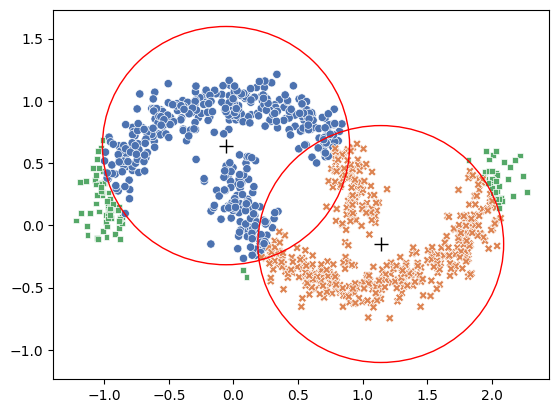

silhouette score:  0.48616941623075527
rand score:  0.6279421579532815
completeness score:  0.19437481654887512
even distribution score:  1.3163597092243022
sum of variances:  0.8904412194894034


In [25]:
#metrics for trimmedkmeans 1000 samples from make_moons with noise
plot_clustering(1000,
                2,
                distribution= 'make_moons',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                noise=0.1,
                runs=20)

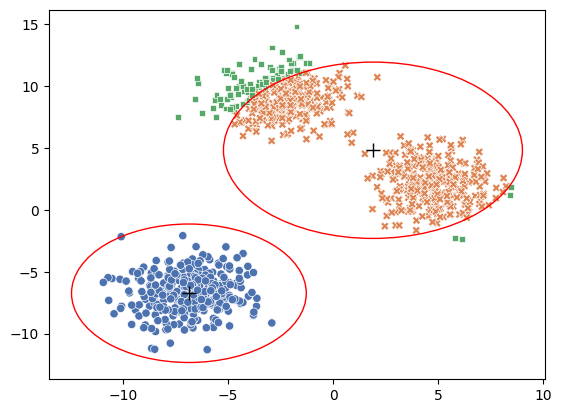

silhouette score:  0.6919890054422684
rand score:  0.806446669138549
completeness score:  0.9999999999999991
even distribution score:  5.301317608667131
sum of variances:  16.71666935173939


In [26]:
#create a dataset with incorrect number of blobs
plot_clustering(1000, 3, distribution= 'make_blobs', cluster_method= 'trimmed_kmeans', cluster_std=1.5, metrics = METRICS, n_cluster=2)

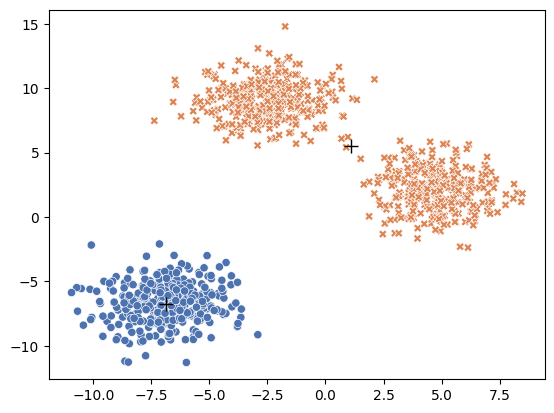

silhouette score:  0.6651097855176108
rand score:  0.7773333333333333
completeness score:  0.9999999999999993


In [27]:
#incorrect number of blobs kmeans
plot_clustering(1000, 3, distribution= 'make_blobs', cluster_method= 'kmeans', cluster_std=1.5, metrics = METRICS, n_cluster=2)

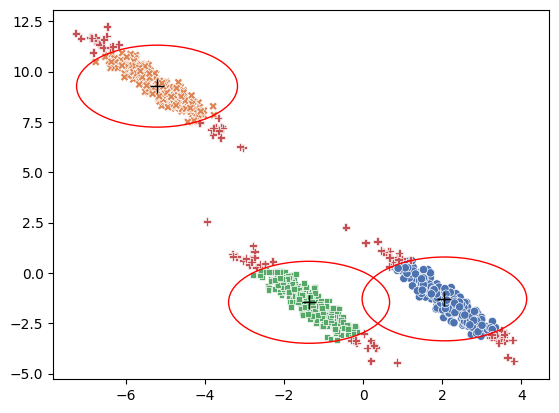

silhouette score:  0.7443782860643349
rand score:  1.0
completeness score:  1.0
even distribution score:  9.804841548809343
sum of variances:  56.83211594672067


In [28]:
#create a dataset with anisotropicly_distributed of blobs
plot_clustering(1000, 3, distribution= 'anisotropicly_distributed', cluster_method= 'trimmed_kmeans',  metrics = METRICS, runs=10)

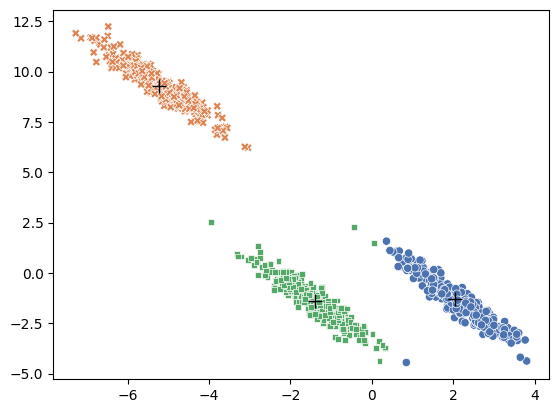

silhouette score:  0.694501223687095
rand score:  0.996018018018018
completeness score:  0.9826775273057718


In [29]:
#anisotropicly_distributed kmeans
plot_clustering(1000, 3, distribution= 'anisotropicly_distributed', cluster_method= 'kmeans',  metrics = METRICS)

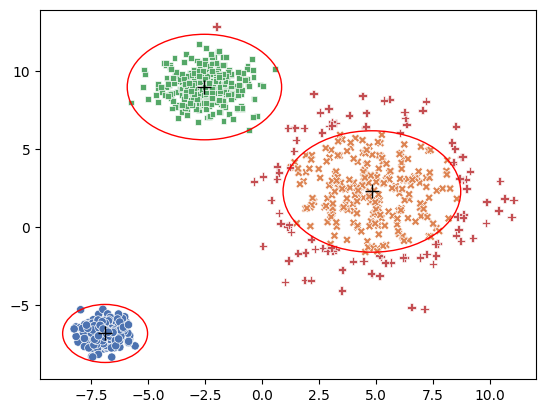

silhouette score:  0.8314190161796378
rand score:  0.9972067729576072
completeness score:  0.988209107156318
even distribution score:  8.469156039084769
sum of variances:  38.84061822338352


In [30]:
#create a dataset with different variance between blobs
plot_clustering(1000, 3, distribution= 'different_variance', cluster_method= 'trimmed_kmeans',  metrics = METRICS, runs=10)

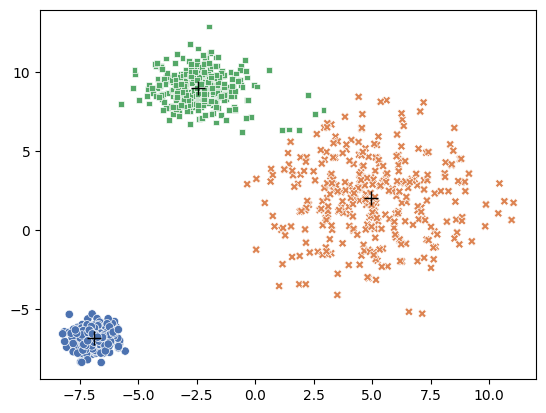

silhouette score:  0.7766773890895171
rand score:  0.9894454454454454
completeness score:  0.9656474039460591


In [31]:
#different variance kmeans
plot_clustering(1000, 3, distribution= 'different_variance', cluster_method= 'kmeans',  metrics = METRICS)

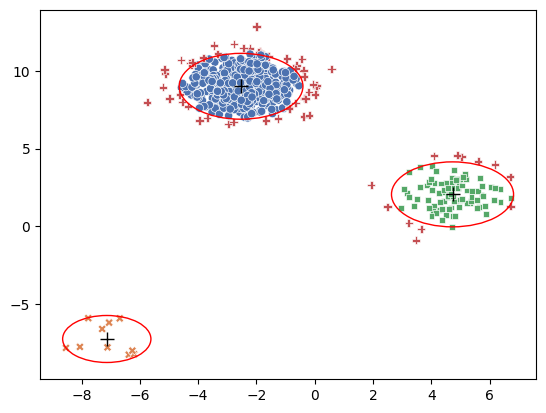

silhouette score:  0.8499832088872258
rand score:  1.0
completeness score:  1.0
even distribution score:  8.241005313171563
sum of variances:  37.184754721610446


In [32]:
#create a dataset with unevenly sized blobs
plot_clustering(610, 3, distribution= 'unevenly_sized', cluster_method= 'trimmed_kmeans',  metrics = METRICS, runs=100)

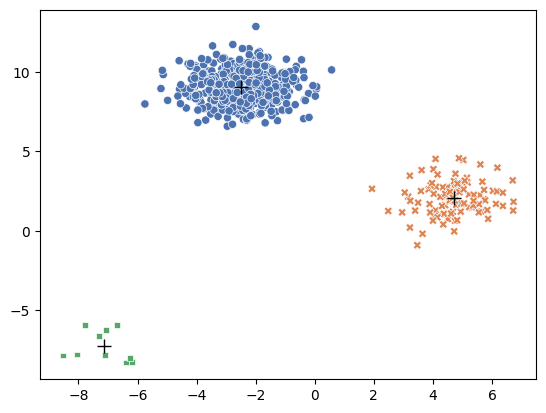

silhouette score:  0.8273199874353518
rand score:  1.0
completeness score:  1.0


In [33]:
#unevenly sized blobs kmeans
plot_clustering(610, 3, distribution= 'unevenly_sized', cluster_method= 'kmeans',  metrics = METRICS, runs=20)

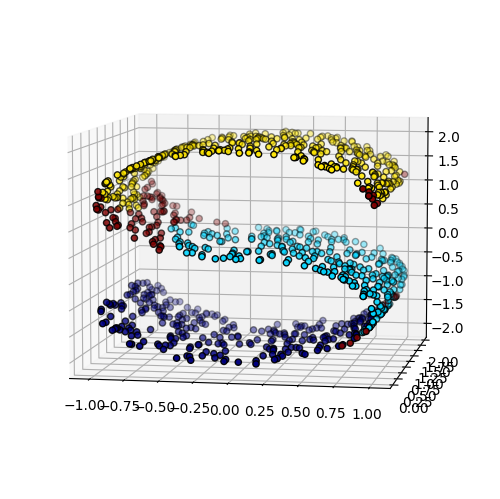

silhouette score:  0.42314547277186265
rand score:  0.6609244839945618
completeness score:  0.9999999999999998
even distribution score:  2.8872817834345534
sum of variances:  2.9012617427195626


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [34]:
#metrics for trimmedkmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_s_curve',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                runs=20)

In [35]:
#metrics for kmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_s_curve',
                cluster_method= 'kmeans',
                metrics = METRICS,
                plot= False,
                runs=20)

silhouette score:  0.37206771983920034
rand score:  0.649927927927928
completeness score:  1.0000000000000007


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


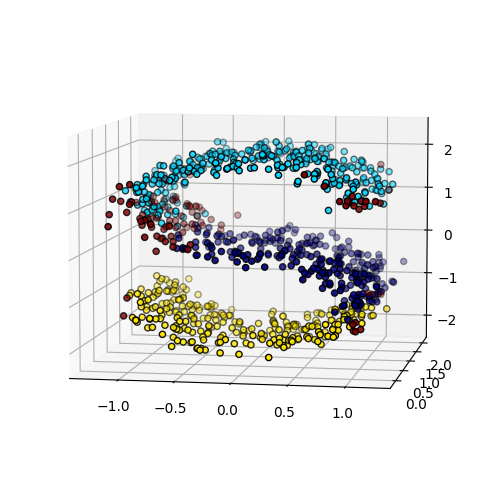

silhouette score:  0.4055981427367444
rand score:  0.6613100976393523
completeness score:  0.9999999999999998
even distribution score:  2.8837093994335423
sum of variances:  2.900594165971034


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [36]:
#metrics for trimmedkmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_s_curve',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                noise= 0.1,
                runs=20)

In [37]:
#metrics for kmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_s_curve',
                cluster_method= 'kmeans',
                metrics = METRICS,
                noise = 0.1,
                plot= False,
                runs=20)

silhouette score:  0.3603660345278942
rand score:  0.6532952952952953
completeness score:  1.0000000000000004


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


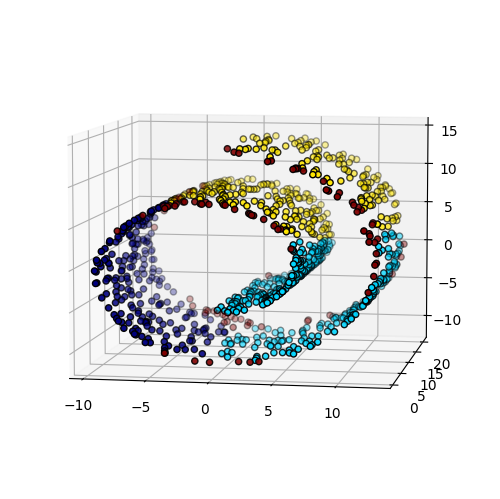

silhouette score:  0.3177507897090532
rand score:  0.6497565195896675
completeness score:  1.0000000000000004
even distribution score:  21.78089963485261
sum of variances:  161.61800318798075


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [38]:
#metrics for trimmedkmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_swiss_roll',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                runs=20)

In [39]:
#metrics for kmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_swiss_roll',
                cluster_method= 'kmeans',
                metrics = METRICS,
                plot= False,
                runs=20)

silhouette score:  0.2895356288500472
rand score:  0.6537017017017017
completeness score:  0.9999999999999998


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


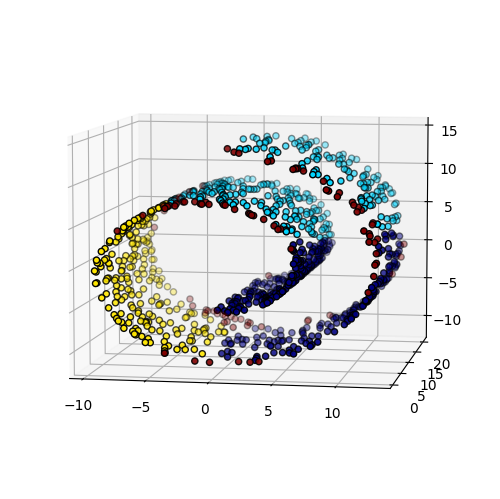

silhouette score:  0.3177507897090532
rand score:  0.6497565195896675
completeness score:  1.0000000000000002
even distribution score:  21.78089963485261
sum of variances:  161.61800318798075


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [40]:
#metrics for trimmedkmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_swiss_roll',
                cluster_method= 'trimmed_kmeans',
                metrics = METRICS,
                runs=20)

In [41]:
#metrics for kmeans 1000 samples from make_s_curve 
plot_clustering(1000,
                3,
                distribution= 'make_swiss_roll',
                cluster_method= 'kmeans',
                metrics = METRICS,
                plot= False,
                runs=20)

silhouette score:  0.2895356288500472
rand score:  0.6537017017017017
completeness score:  0.9999999999999998


C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
